<a href="https://colab.research.google.com/github/kamser0415/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
# 버전이 달라지면
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 604.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 7s (1,464 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [3]:
import requests
from lxml import etree ## xml을 트리형태로
from lxml.html import fromstring ## html을 tree 형태로
import pandas as pd

## RSS 데이터는 리치 사이트 서머리로 웹 1.0 시절에 뉴스나 잡지를 보고 싶을 때 그 사이트에 접속해서
## 필요한 기능을 RSS를 갱신하는 것을 말한다.
## XML 포멧으로 돌아오니 그걸 응용해서 실습을 진행한다.
## VML 시각 언어 모델(VLM)은 이미지와 동영상 또는 텍스트를 같이 넣어서 언어적인 설명을 같이 한다.

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'): ## item 태그를 가져온다
            description = item.find('description') ## item 태그 내
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img//@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [4]:
from IPython.display import display, HTML ## 파이썬에서 이미지를 보는 방법

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
## 알수 있는 부분이다.
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [5]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## VLM은 이미지를 언어로 바꾸는 것이다.
## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
## int가 들어가면 경량화된 버전이다.
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [9]:
from transformers import set_seed ## 랜덤함수의 시드를 맞춘다.

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [10]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [11]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [12]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'is this a picture of clothing? Must say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

yes
No.
yes
yes
yes
yes
yes
yes
yes
No.
yes
No.


## 14-6 의류 판단 결과 시각화

In [16]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
2,,True
3,,True
4,,True
5,,True
6,,True
7,,True
8,,True
10,,True


## 14-7 의류 이미지 필터링

In [15]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

## 14-8 의류 스타일 분석

In [17]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

In [18]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes in the image is reminiscent of military or utilitarian fashion, characterized by its functional design and muted color palette. The olive green jacket with its relaxed fit and large pockets suggests a practical garment designed for ease of movement and utility, which is often seen in workwear or casual outerwear.\n\nIn terms of colors, the use of earth tones like olive green and beige is consistent with trends that favor natural, subdued hues over bright, bold colors. This preference for neutral tones can be associated with a minimalist aesthetic that values simplicity and versatility in clothing.\n\nThe trend changes noted here are likely reflective of broader shifts in fashion towards more sustainable and timeless pieces. Military-inspired clothing has been experiencing a resurgence in popularity due to its classic silhouette and durability. The relaxed fit also aligns with contemporary fashion trends that prioritize comfort alongside functionality.\n\nOverall, the clothing style depicted in the image seems to blend traditional military influences with modern, casual fashion sensibilities, creating a look that is both stylish and practical."
2,,True,"The style of the clothes in the image reflects a casual, possibly urban fashion sense. The denim jacket is a staple piece that has been popular for many decades and remains a timeless choice due to its versatility and durability. Denim's enduring popularity can be attributed to its ability to complement various body types and styles, making it a favored fabric among fashion enthusiasts.\n\nThe color palette of the outfit consists of neutral tones—navy blue and beige. Navy is often associated with sophistication and depth, while beige is considered versatile and easy to pair with other colors. This combination suggests a preference for classic and understated elegance over bold or trendy colors.\n\nThe layering of the shirt underneath the jacket adds to the relaxed yet put-together look. Layering is a common trend in contemporary fashion as it allows for adjustments based on temperature changes and provides an opportunity to mix textures and fabrics.\n\nOverall, the clothing choices suggest a modern take on classic styles, indicating a blend of comfort and style that is both approachable and fashionable."
3,,True,"The style of the clothes worn by the individual in the image suggests a preference for classic and possibly vintage-inspired fashion. The brown jacket and pants have a textured appearance, which is often associated with casual or outdoor wear, designed to be both functional and stylish. The color choice of brown is timeless and versatile, commonly used in outerwear for its ability to blend with various settings and seasons.\n\nIn terms of trend changes, the outfit does not appear to follow the latest fast-fashion trends that are characterized by bold colors, patterns, and frequent updates. Instead, it leans towards a more subdued and perhaps retro aesthetic, which has seen a resurgence in popularity over recent years. This trend reflects a return to basics and an appreciation for simplicity and durability in clothing choices.\n\nOverall, the attire can be described as understated yet thoughtful, indicating a personal style that values comfort and practicality while also showing an awareness of traditional fashion elements."
4,,True,"The style of the shoes in the image is indicative of a classic and timeless design, often associated with casual or smart-casual fashion. The suede material and the chukka boot silhouette suggest a preference for comfortable yet stylish footwear that can be worn in various settings. Suede, as a material, is known for its soft texture and has been popular in shoe designs for many years due to its versatility.\n\nIn terms of color trends, the dark brown or grey tone of these shoes is quite neutral and can easily match with a wide range of colors and outfits. This choice of color sugges

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [20]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

config.json: 0.00B [00:00, ?B/s]

INFO 11-25 14:32:02 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 11-25 14:32:25 config.py:549] This model supports multiple tasks: {'embed', 'classify', 'generate', 'reward', 'score'}. Defaulting to 'generate'.
INFO 11-25 14:32:25 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 11-25 14:32:28 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-25 14:32:28 cuda.py:226] Using XFormers backend.
INFO 11-25 14:32:29 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 11-25 14:32:29 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 11-25 14:35:41 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 192.255450 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 11-25 14:36:22 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 11-25 14:36:25 worker.py:267] Memory profiling takes 2.61 seconds
INFO 11-25 14:36:25 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 11-25 14:36:25 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 11-25 14:36:25 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 11-25 14:36:25 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 11-25 14:36:32 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]

INFO 11-25 14:37:19 model_runner.py:1562] Graph capturing finished in 47 secs, took 0.21 GiB


INFO 11-25 14:37:20 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 58.12 seconds


## 14-10 색상 정보 추출

In [21]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요 \n{style}." # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 11-25 14:37:25 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, est. speed input: 297.78 toks/s, output: 10.08 toks/s]


**색상:**
- 올리브 그린


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s, est. speed input: 1063.77 toks/s, output: 27.78 toks/s]


색상: 네이비 블루, 베이지


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s, est. speed input: 1216.03 toks/s, output: 29.07 toks/s]


**색상:** 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, est. speed input: 1051.92 toks/s, output: 28.43 toks/s]


색상: 어두운 갈색 또는 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, est. speed input: 612.76 toks/s, output: 34.04 toks/s]


- 민트 그린 (Mint Green)
- 라이트 블루 (Light Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, est. speed input: 718.88 toks/s, output: 19.69 toks/s]


**색상:**
- 베이지


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s, est. speed input: 761.97 toks/s, output: 12.65 toks/s]


색상: 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, est. speed input: 846.85 toks/s, output: 31.47 toks/s]


**색상:**
- **어두운 갈색**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s, est. speed input: 796.38 toks/s, output: 32.07 toks/s]

- beige
- brown
- grey
- red


## 14-11 스타일 키워드 추출

In [23]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 다른 정보는 적지말아주세요 \n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, est. speed input: 137.78 toks/s, output: 28.98 toks/s]


- **군사적**
- **실용적**
- ** muted**
- **실용성**
- **자연주의**
- **미니멀리즘**
- **지속가능성**
- **재생산**
- **편안함**


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, est. speed input: 102.85 toks/s, output: 41.06 toks/s]


- **casual**
- **urban**
- **timeless**
- **versatile**
- **durable**
- **neutral tones**
- **navy blue**
- **beige**
- **sophisticated**
- **classic**
- **understated elegance**
- **layered**
- **relaxed**
- **put-together**
- **modern**
- **comfortable**
- **fashionable**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, est. speed input: 263.81 toks/s, output: 39.16 toks/s]


- **클래식**
- **빈티지**
- **텍스처**
- **실용적**
- **심플**
- **전통적**
- **기본**


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 94.07 toks/s, output: 40.98 toks/s]


- **클래식** (Classic)
- **타임리스** (Timeless)
- **캐주얼** (Casual)
- **스마트캐주얼** (Smart-casual)
- **편안함** (Comfort)
- **스타일** (Stylish)
- **수디드** (Suede)
- **중립적** (Neutral)
- **실용성** (Practicality)
- **전통적** (Traditional)
- **현대적** (Contemporary)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, est. speed input: 226.04 toks/s, output: 38.52 toks/s]


- **캐주얼**
- **스트리트웨어**
- **클래식**
- **버퍼티컬**
- **다층**
- **기능적**
- **빈티지**
- **개성**
- **편안함**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it, est. speed input: 234.49 toks/s, output: 38.69 toks/s]


스타일 키워드:
- 미니멀리즘
- 실용주의
- 중성색 (베이지 톤)
- 편안함
- 기능성
- 자연스러운 톤
- 레이어링
- 현대적 접근
- 지속가능성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, est. speed input: 136.08 toks/s, output: 40.94 toks/s]


- **현대적** (Modern)
- **미니멀리즘** (Minimalism)
- **단색** (Monochromatic)
- **세련됨** (Sophistication)
- **편안함** (Comfort)
- **실용성** (Functionality)
- **비대칭** (Asymmetry)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, est. speed input: 127.60 toks/s, output: 40.27 toks/s]


- **편안함** (Comfort)
- **따뜻함** (Warmth)
- **단색** (Monochromatic)
- **플레이풀** (Playful)
- **고급스러움** (Sophistication)
- **텍스처** (Texture)
- **볼륨감** (Volume)
- **실용성** (Practicality)
- **미니멀리즘** (Minimalism)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 136.51 toks/s, output: 40.10 toks/s]

- **미니멀리즘**
- **캐주얼**
- **자연재료**
- **무채색**
- **지구적**
- **속삭임**
- **팝 오브 컬러**
- **편안함**
- **현대적**
- **도시 캐주얼**
- **기능성**
- **빈티지 영감**
- **타임리스**
- **유연성**


In [24]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the clothes in the image is reminiscent of military or utilitarian fashion, characterized by its functional design and muted color palette. The olive green jacket with its relaxed fit and large pockets suggests a practical garment designed for ease of movement and utility, which is often seen in workwear or casual outerwear.\n\nIn terms of colors, the use of earth tones like olive green and beige is consistent with trends that favor natural, subdued hues over bright, bold colors. This preference for neutral tones can be associated with a minimalist aesthetic that values simplicity and versatility in clothing.\n\nThe trend changes noted here are likely reflective of broader shifts in fashion towards more sustainable and timeless pieces. Military-inspired clothing has been experiencing a resurgence in popularity due to its classic silhouette and durability. The relaxed fit also aligns with contemporary fashion trends that prioritize comfort alongside functionality.\n\nOverall, the clothing style depicted in the image seems to blend traditional military influences with modern, casual fashion sensibilities, creating a look that is both stylish and practical.",**색상:**\n- 올리브 그린,- **군사적**\n- **실용적**\n- ** muted**\n- **실용성**\n- **자연주의**\n- **미니멀리즘**\n- **지속가능성**\n- **재생산**\n- **편안함**
2,,True,"The style of the clothes in the image reflects a casual, possibly urban fashion sense. The denim jacket is a staple piece that has been popular for many decades and remains a timeless choice due to its versatility and durability. Denim's enduring popularity can be attributed to its ability to complement various body types and styles, making it a favored fabric among fashion enthusiasts.\n\nThe color palette of the outfit consists of neutral tones—navy blue and beige. Navy is often associated with sophistication and depth, while beige is considered versatile and easy to pair with other colors. This combination suggests a preference for classic and understated elegance over bold or trendy colors.\n\nThe layering of the shirt underneath the jacket adds to the relaxed yet put-together look. Layering is a common trend in contemporary fashion as it allows for adjustments based on temperature changes and provides an opportunity to mix textures and fabrics.\n\nOverall, the clothing choices suggest a modern take on classic styles, indicating a blend of comfort and style that is both approachable and fashionable.","색상: 네이비 블루, 베이지",- **casual**\n- **urban**\n- **timeless**\n- **versatile**\n- **durable**\n- **neutral tones**\n- **navy blue**\n- **beige**\n- **sophisticated**\n- **classic**\n- **understated elegance**\n- **layered**\n- **relaxed**\n- **put-together**\n- **modern**\n- **comfortable**\n- **fashionable**
3,,True,"The style of the clothes worn by the individual in the image suggests a preference for classic and possibly vintage-inspired fashion. The brown jacket and pants have a textured appearance, which is often associated with casual or outdoor wear, designed to be both functional and stylish. The color choice of brown is timeless and versatile, commonly used in outerwear for its ability to blend with various settings and seasons.\n\nIn terms of trend changes, the outfit does not appear to follow the latest fast-fashion trends that are characterized by bold colors, patterns, and frequent updates. Instead, it leans towards a more subdued and perhaps retro aesthetic, which has seen a resurgence in popularity over recent years. This trend reflects a return to basics and an appreciation for simplicity and durability in clothing choices.\n\nOverall, the attire can be described as understated yet thoughtful, indicating a personal style that values comfort and practicality while also showing an awareness of traditional fashion elements.",**색상:** 갈색,- **클래식**\n- **빈티지**\n- **텍스처**\n- **실용적**\n- **심플**\n- **전통적**\n- **기본**
4,,True,"The style of the shoes in the image is indicative of a cla

## 14-12 텍스트 데이터 정제

In [25]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

## 14-13 워드 클라우드 생성 및 시각화

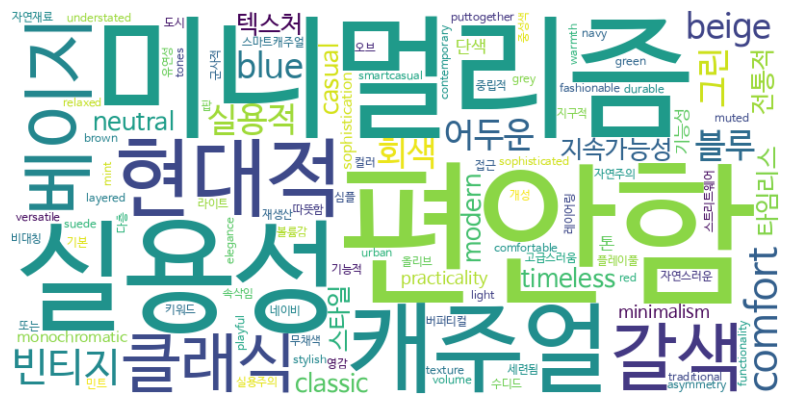

In [26]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [27]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
    ## 이미지 있었고 색상 , 스타일을 가지고 튜플형태로 프롬프트에 전달하는 것이다.
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n 이미지 url: {row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트랜드 방향의 분석 보고서를 작성해주세요, 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서 형식은 markdown로 만들어주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:17<00:00, 17.25s/it, est. speed input: 156.91 toks/s, output: 37.91 toks/s]


In [28]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 개요
본 보고서는 최근 여러 패션 룩북에서 관찰되는 주요 스타일 트렌드를 종합적으로 분석하고, 그 특징과 미래 전망을 제시합니다. 주요 분석 대상은 다양한 색상 팔레트, 소재 선택, 실루엣 및 액세서리 활용 등에 초점을 맞추었습니다.

## 트렌드 분석

### 1. **미니멀리즘과 실용성의 융합**
- **색상 팔레트**: 중성적인 톤(베이지, 그레이, 올리브 그린 등)이 주를 이루며, 이는 자연스러운 톤과 함께 다양한 계절에 걸쳐 유연하게 착용 가능한 특성을 제공합니다.
- **소재**: 천연 소재와 기능성 소재의 혼합이 두드러집니다. 예를 들어, suede와 denim, 코튼 소재의 활용은 편안함과 스타일을 동시에 추구합니다.
- **실루엣**: 오버사이즈와 루즈핏이 인기를 끌고 있으며, 이는 편안함과 실용성을 강조합니다. 특히, 클래식한 실루엣에 현대적인 터치를 더한 디자인이 주목받고 있습니다.

### 2. **기능성과 스타일의 균형**
- **기능성 요소**: 실용적인 디자인 요소가 강조됩니다. 예를 들어, 큰 포켓, 벨트 루프, distressed details 등은 일상적인 활동성을 높입니다.
- **액세서리 활용**: 단순하면서도 세련된 액세서리가 주요 포인트입니다. 특히, 단색의 색상 대비를 이루는 액세서리나, 한 가지 색상의 강렬한 포인트가 전체 룩을 돋보이게 합니다.

### 3. **지속 가능성과 클래식의 결합**
- **지속 가능한 패션**: 자연스러운 색상과 친환경 소재의 사용이 증가하고 있으며, 이는 트렌드의 장기적인 지속 가능성에 대한 관심을 반영합니다.
- **클래식의 현대적 해석**: 과거의 클래식 스타일이 현대적인 감각으로 재해석되고 있습니다. 예를 들어, military-inspired clothing과 vintage-inspired textures의 융합이 주목받고 있습니다.

### 4. **계절별 트렌드**
- **겨울 패션**: 따뜻함과 편안함을 중시하는 디자인이 주를 이루며, 고밀도 소재와 높은 넥라인이 특징입니다.
- **봄/가을 패션**: 중성적인 색상 팔레트와 가벼운 소재의 조합이 인기입니다. 레이어링과 다양한 텍스처의 활용이 특징적입니다.

## 결론
최근 패션 트렌드는 기능성과 스타일의 균형, 지속 가능성, 그리고 클래식한 요소의 현대적 해석을 중심으로 발전하고 있습니다. 이러한 방향성은 소비자들이 편안함과 실용성을 추구하면서도 개인의 스타일을 표현하고자 하는 욕구를 반영하고 있습니다. 앞으로도 이러한 요소들이 융합되면서 더욱 다양하고 개성적인 패션 스타일이 등장할 것으로 예상됩니다.

---

이 보고서는 다양한 패션 룩북에서 관찰된 패턴과 트렌드를 종합적으로 분석하여 미래 패션 산업의 방향성을 예측하고자 작성되었습니다.